<a href="https://colab.research.google.com/github/Kishan-Kumar-Zalavadia/Material-Science/blob/main/code_9_(Read_multiple_files).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Static variables

In [1]:
# # Define column names
# x_axis = 't.strain'
# y1_axis = 't.stress'
# y2_axis = 'hard.Rate'

# Set the value of k for spline interpolation
k_value = 5

ee = 0.001

# Excel data file path
# file_path = '/content/Data.xlsx'

# PDF path for the research paper
# pdf_file_path = "/content/8.pdf"

# link to the research paper
link = "http://www/google.com"


# Keywords to search for
keywords = {"stress", "strain", "additive manufacturing", "cast", "forge", "powder", "rolling", "extrusion"}


# All import statments

In [15]:
# Install PyPDF2 package
!pip install PyPDF2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, CubicSpline
import re
from PyPDF2 import PdfReader
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string
import json
import os
import PyPDF2


# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

- The above code block assigns the values to variables.
- x_axis: column name of the x-axis in Excel sheet
- y_axis: column name of the y-axis in Excel sheet
- k_value is the polynomial degree which will be used to find the b0 value.
- flie_path: The path of the Excel sheet
- pdf_file_path: The file path of the research paper (format as pdf)
- keywords: An array of keywords that you wish to find in the research paper.



# Find best paraameters

# Find Best B0 in a method

In [4]:
def calculate_b0_range(file_path, x_axis, y2_axis, k_value):


    # Read Excel file
    df = pd.read_excel(file_path)

    # Remove the last row
    df = df.drop(df.tail(2).index)

    # Extract x and y columns
    x = df[x_axis].values
    y = df[y2_axis].values

    # Check for and handle NaN or infinite values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    # Perform cubic spline interpolation
    spline_interp = make_interp_spline(x, y, k=k_value)

    # Generate new x values for interpolation
    x_new = np.linspace(min(x), max(x), 100)

    # Perform interpolation
    y_new = spline_interp(x_new)

    # Fit cubic polynomial to the entire dataset
    coefficients = np.polyfit(x, y, k_value)

    # Print the coefficients
    print("Cubic Polynomial Coefficients:", coefficients)

    # Generate y values for the cubic polynomial
    y_cubic = np.polyval(coefficients, x_new)

    # Dynamic equation print
    cubic_equation = "Polynomial Equation: "
    for i, coef in enumerate(coefficients):
        cubic_equation += f"{coef:.6f} x^{k_value-i} + " if i < k_value else f"{coef:.6f}"
    print()

    # Remove the trailing ' + ' at the end
    cubic_equation = cubic_equation.rstrip(' + ')
    print(cubic_equation)
    print()

    # Take the derivative of the polynomial
    derivative_coefficients = np.polyder(coefficients)

    # Dynamic equation print for the derivative
    derivative_equation = "Derivative Equation: "
    for i, coef in enumerate(derivative_coefficients):
        derivative_equation += f"{coef:.6f} x^{k_value-1 -i} + " if i < k_value-1 else f"{coef:.6f}"

    # Remove the trailing ' + ' at the end
    derivative_equation = derivative_equation.rstrip(' + ')
    print(derivative_equation)
    print()

    # Find the roots (zeros) of the derivative equation
    roots = np.roots(derivative_coefficients)
    print("Roots (Zeros) of the Derivative Equation:", roots)
    print()

    # Calculate y values for each root using the original cubic polynomial
    y_roots = np.polyval(coefficients, roots)

    # Print the corresponding y values for the roots
    for i, root in enumerate(roots):
        print(f"For x = {root:.6f}, y = {y_roots[i]:.6f}")
    print()

    # Plot the original data, interpolated curve, and cubic polynomial
    plt.scatter(x, y, label='Original Data')
    plt.plot(x_new, y_new, label='Interpolated Curve', color='red')
    plt.plot(x_new, y_cubic, label='Polynomial', linestyle='dashed', color='green')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.title('Interpolation and Polynomial Fit')
    plt.show()

    # Filter out the original y values and assign them back
    y_roots = [np.real(y_roots[i]) for i in range(len(roots)) if np.isclose(np.imag(y_roots[i]), 0)]

    # Print the corresponding y values for the original roots
    print("Original Y Values for the Roots:")
    for root, y_value in zip(roots, y_roots):
        if np.isclose(np.imag(y_value), 0):
            print(f"For x = {root:.6f}, y = {y_value:.6f}")
    print()

    # Sort the y_roots array
    y_roots_sorted = np.sort(y_roots)

    # Find the differences between consecutive roots
    differences = np.diff(y_roots_sorted)

    # Find the index of the minimum difference
    min_diff_index = np.argmin(differences)

    # Determine the indices of the two closest roots
    index1 = min_diff_index
    index2 = min_diff_index + 1

    # Store the minimum and maximum values
    min_b0 = min(y_roots_sorted[index1], y_roots_sorted[index2])
    max_b0 = max(y_roots_sorted[index1], y_roots_sorted[index2])

    print("Minimum b0:", min_b0)
    print("Maximum b0:", max_b0)

    # Round down min_b0 to the nearest hundred
    rounded_min_b0 = int(min_b0 // 100) * 100

    # Calculate from_b0 and to_b0
    from_b0 = rounded_min_b0 - 100
    to_b0 = rounded_min_b0 + 200

    # Print from_b0 and to_b0
    print("From_b0:", from_b0)
    print("To_b0:", to_b0)

    return from_b0, to_b0




- The above code find the best b0_value.
- Step 1: Generate a polynomial equation of k degree.
- Step 2: Find the derivative of that equation.
- Step 3: Find the roots of that derivative.
- Step 4: Substitute the roots in the original equation to get the b0_values.
- The number of b0_values that you get is k-1.

- The above code extracts the original b0_values.
- The 2 y values that are close to each other are the original values out of all the values.

- To get accurate b0_values we consider some values which are less than and greater than b0_values.

# Find Best D1 in a method

In [5]:
def calculate_min_max_slope(file_path, x_axis, y2_axis):

    # Set display options to show all rows and columns
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    # Define the column names
    column_names = [x_axis, y2_axis]

    # Read only the specified columns from Excel file
    data = pd.read_excel(file_path, usecols=column_names)

    # Drop rows with missing or non-finite values
    data.dropna(inplace=True)

    # Extract x and y values
    x = data[column_names[0]].values
    y = data[column_names[1]].values

    # Fit a cubic spline to the data
    cs = CubicSpline(x, y)

    # Calculate the slope for each data point
    slopes = cs(x, 1)

    # Print the slopes along with their corresponding x and y values
    print("Point   |   x       |   y       |   Slope")
    print("---------------------------------------------")
    for i, (x_val, y_val, slope_val) in enumerate(zip(x, y, slopes)):
        print(f"{i+1}       |   {x_val:.3f}   |   {y_val:.3f}   |   {slope_val:.3f}")

    # Plot the original data and cubic spline
    plt.figure(figsize=(12, 8))
    plt.plot(x, y, 'bo', label='Data')
    plt.plot(x, cs(x), 'r-', label='Cubic Spline')
    plt.xlabel(column_names[0])
    plt.ylabel(column_names[1])
    plt.title('Original Data and Cubic Spline Fit')
    plt.legend()

    plt.show()

    # Filter out negative slopes and their corresponding x, y values
    positive_slope_indices = np.where(slopes > 0)[0]
    x_positive = x[positive_slope_indices]
    y_positive = y[positive_slope_indices]

    # Calculate the differences between consecutive slopes
    slope_diffs = np.diff(slopes[positive_slope_indices])

    # Consider only the first 10 values or the available maximum
    max_values = min(5, len(x_positive))
    x_positive = x_positive[:max_values]
    y_positive = y_positive[:max_values]
    slope_diffs = slope_diffs[:max_values-1]  # As there are max_values-1 differences for max_values values

    # Initialize an empty array to store the slopes for which the information is printed
    printed_slopes = []

    # Plot the original data and cubic spline
    plt.figure(figsize=(12, 8))
    plt.plot(x, y, 'bo', label='Data')
    plt.plot(x, cs(x), 'r-', label='Cubic Spline')
    plt.xlabel(column_names[0])
    plt.ylabel(column_names[1])
    plt.title('Original Data and Cubic Spline Fit')
    plt.legend()

    # Add point numbers with a gap above the points in the plot
    gap = 50  # Adjust the gap as needed
    for i, (x_val, y_val) in enumerate(zip(x_positive, y_positive)):
        plt.text(x_val, y_val + gap, f"{i+1}", fontsize=10, ha='center', va='center')
        printed_slopes.append(slopes[positive_slope_indices][i])

    plt.grid(True)

    # Store data point, x, y, and its difference in a new array
    data_and_differences = np.column_stack((x_positive[:-1], y_positive[:-1], slope_diffs, printed_slopes[:-1]))

    print("Data Point | x Value | y Value | Difference | Slope:")
    print("----------------------------------------------------")
    for i, (x_val, y_val, diff, slope) in enumerate(data_and_differences):
        print(f"{i+1}       |   {x_val:.3f}   |   {y_val:.3f}   |   {diff:.3f}   |   {slope:.3f}")

    # Calculate the average of the slopes
    average_slope_printed = np.mean(printed_slopes[:-1])
    print("\nAverage Slope of Printed Slopes:", average_slope_printed)

    plt.show()

    max_d1 = printed_slopes[0]
    min_d1 = printed_slopes[0]

    # Iterate through printed slopes to find max and min
    for slope in printed_slopes[1:]:
        if slope > max_d1:
            max_d1 = slope
        elif slope < min_d1:
            min_d1 = slope

    # Print the maximum and minimum slopes
    print("\nMinimum Slope:", min_d1)
    print("Maximum Slope:", max_d1)

    return min_d1, max_d1


- The above code generate the slopes of the curve at each data points.

- The above code calculates the difference between consecutive slopes.

- The above code narrow down the slopes.
- It finds the slope where there is a rapid change in the first part of the curve, the d1 ranges somewhere near that slope.

- The above code finds the average slope out of the narrowed slopes.

- The above considers the maximum and minimum slopes in the narrowed slopes.
- The d1 lies between the minimum and maximum slope.

# Find all best parametes in a methods

In [6]:
def find_best_parameters(file_path, x_axis, y2_axis, from_b0, to_b0, min_d1, max_d1, ee):

    # Read data from Excel file using global file_path, x_axis, and y2_axis
    data = pd.read_excel(file_path)
    original_results = data[y2_axis].values
    ep_values = data[x_axis].values

    # Define function to calculate MSE
    def calculate_mse(b0, d1, d2, ei):
        calculated_results = []
        for ep in ep_values:
            if abs((ep - ei) / (ei + ee)) < 1:
                result = b0 - d1 * ((abs((ep - ei) / (ei + ee)) * np.arctanh((ep - ei) / (ei + ee))) - (d2 * ((ep - ei) / (ei + ee))))
                calculated_results.append(result)
            else:
                calculated_results.append(None)  # Handle cases where the condition is not met
        valid_results = [result for result in calculated_results if result is not None]  # Filter out None values
        mse = np.mean((np.array(original_results[:len(valid_results)]) - np.array(valid_results)) ** 2)
        euclidean_distance = np.sqrt(np.sum([(x - y) ** 2 for x, y in zip(original_results, valid_results)]))
        return euclidean_distance

    # Initialize variables to store best parameters
    best_b0 = None
    best_d1 = None
    best_d2 = None
    best_ei = None
    min_mse = float('inf')

    # Nested loops to iterate over B0, D1, D2, and Ei values using global from_b0, to_b0, min_d1, max_d1
    for b0_value in range(from_b0, to_b0, 10):
        for d1_value in np.arange(min_d1, max_d1, 5):
            for d2_value in np.arange(0.2, 0.5, 0.05):
                for ei_value in np.arange(0.1, 0.285, 0.05):
                    mse_value = calculate_mse(b0_value, d1_value, d2_value, ei_value)
                    if mse_value < min_mse:
                        min_mse = mse_value
                        best_b0 = b0_value
                        best_d1 = d1_value
                        best_d2 = d2_value
                        best_ei = ei_value

    return best_b0, best_d1, best_d2, best_ei, min_mse




- The above code defines a method that calculates the mean square error (euclidean distance) based on the formula given in the paper which contains the 5 parameters.

- The above code runs loops to find the best parameter combination.
- The original points (given in the excel sheet) are compared with the y values that are generated by the equations.
- The combination which has least error is the best parameter combination.
- We have narrowed the b0 and d1 values which makes the loop run quickly and efficiently.

# Comparision graph in a method

In [7]:
def plot_comparison(file_path, x_axis, y2_axis, best_b0, best_d1, best_d2, ee, best_ei):

    # Read data from Excel file
    data = pd.read_excel(file_path)
    x_values = data[x_axis].values
    original_x_values = data[x_axis].values
    original_y_values = data[y2_axis].values

    # Define function to calculate y values
    def calculate(b0, d1, d2, ee, ei, ep):
        result = np.zeros_like(ep)
        for i in range(len(ep)):
            if abs((ep[i] - ei) / (ei + ee)) < 1:
                result[i] = b0 - d1 * ((abs((ep[i] - ei) / (ei + ee)) * np.arctanh((ep[i] - ei) / (ei + ee))) - (d2 * ((ep[i] - ei) / (ei + ee))))
        return result

    # Calculate y values using the provided function
    y_values = calculate(best_b0, best_d1, best_d2, ee, best_ei, x_values)

    # Plot x-y values
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, label='Calculated', color='blue')
    plt.plot(original_x_values, original_y_values, label='Original', color='red')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Comparison of Calculated and Original Data')
    plt.legend()
    plt.grid(True)
    plt.show()




- In the above code we compare the original graph with the graph values generated by the equation from the parameters we found in the above step.

# Extrract Keywords in a method

In [8]:
def extract_and_find_lemmas(pdf_file_path, keywords):
    all_lemmas = []

    # Parse the PDF and extract text
    text = ""
    try:
        with open(pdf_file_path, "rb") as f:
            pdf_reader = PyPDF2.PdfReader(f)
            num_pages = len(pdf_reader.pages)
            for page_number in range(num_pages):
                text += pdf_reader.pages[page_number].extract_text()
    except PyPDF2.utils.PdfReadError as e:
        print("Error reading PDF file:", e)
        return None, None
    except Exception as e:
        print("An error occurred:", e)
        return None, None

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stop words and punctuation, and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    for word in words:
        if word.lower() not in stop_words and word not in string.punctuation:
            lemma = lemmatizer.lemmatize(word, pos=get_wordnet_pos(word))
            for keyword in keywords:
                if keyword in lemma and lemma not in all_lemmas:
                    all_lemmas.append(lemma)

    return text, all_lemmas

# Function to map POS tag to first character lemmatize() accepts
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)





- The above code reads the pdf paper and extracts the keywords using natural language processing libraries.

# Extract the chemical composition in a method

In [17]:
def extract_chemical_compositions_from_pdf(pdf_file_path, min_length=8):
    with open(pdf_file_path, 'rb') as file:
        reader = PdfReader(file)
        text = ''
        for page in reader.pages:
            text += page.extract_text()

    return extract_chemical_compositions(text, min_length)

def extract_chemical_compositions(text, min_length=8):
    pattern = r'\b(?:[A-Z][a-z]?\d*(?:\.\d+)?)+\b'
    chemical_compositions = re.findall(pattern, text)
    # Filter compositions based on minimum length
    chemical_compositions = [comp for comp in chemical_compositions if len(comp) >= min_length]
    return chemical_compositions

def combine_words(text):
    # Split the text into individual words
    words = text.split()

    # Iterate through the words
    i = 0
    while i < len(words) - 1:
        # Check if the current word ends with a number and the next word starts with a character
        if words[i][-1].isdigit() and words[i+1][0].isalpha():
            # Combine the words
            words[i] += words[i+1]
            # Remove the next word
            del words[i+1]
        # Check if the current word ends with a character and the next word starts with a number
        elif words[i][-1].isalpha() and words[i+1][0].isdigit():
            # Combine the words
            words[i] += words[i+1]
            # Remove the next word
            del words[i+1]
        else:
            # Move to the next pair of words
            i += 1

    # Join the words back into a single string
    combined_text = ' '.join(words)
    return combined_text

import re

def create_element_dictionary(chemical_composition):
    # Initialize an empty dictionary to store key-value pairs
    elements = {}

    # Split the composition string into element symbol and numeric value pairs
    # The regular expression (\D+)(\d*\.?\d*) matches non-digit characters (element symbols) followed by optional digits (numeric values)
    matches = re.findall(r'([A-Z][a-z]?)(\d*\.?\d*)', chemical_composition)

    # Iterate through the matches
    for match in matches:
        # Extract the element symbol
        element = match[0]

        # Extract the numeric value, or 0 if not provided
        value = float(match[1]) if match[1] else 1.0

        # Add the element and its value to the dictionary
        elements[element] = value

    return elements




def find_max_size_chemical(text ,pdf_file_path):
    chemicals = extract_chemical_compositions_from_pdf(pdf_file_path)
    combined_text = combine_words(text)
    chemicals = extract_chemical_compositions(combined_text)
    print()
    print(chemicals)
    max_size_chemical = max(chemicals, key=len)
    print("\nMaximum sized chemical composition:", max_size_chemical)
    element_dict = create_element_dictionary(max_size_chemical)
    return element_dict




- The above code also uses a regular expression to extract the chemical composition from the paper.
- The largest composition is considered (assumed) as the main checmical composition.

- Convert the chemical composition into a key-value pair of element and number.

# Create of Update JSON file

In [18]:
def update_json_data(json_file_path, new_details):
    """
    Update existing JSON data with new details and write back to the JSON file.

    Args:
        json_file_path (str): Path to the JSON file.
        new_details (dict): Dictionary containing the new details to insert/update.
    """
    # Check if the JSON file exists
    if os.path.exists(json_file_path):
        # Read the existing JSON data if the file exists
        with open(json_file_path, 'r') as json_file:
            existing_data = json.load(json_file)
    else:
        # If the file doesn't exist, initialize existing_data as an empty list
        existing_data = []

    # Remove the 'id' field if present in new_details
    if 'id' in new_details:
        del new_details['id']

    # Append new details to existing list
    existing_data.append(new_details)

    # Write the updated data back to the JSON file
    with open(json_file_path, 'w') as json_file:
        json.dump(existing_data, json_file, indent=4)

    print("Data has been updated in", json_file_path)


- The above code creates the JSON file if it does not exist and reads the data from it if it exists.

# Call all the methods

In [19]:
def analyze_pdf_data(file_path, pdf_file_path, keywords, x_axis, y2_axis, k_value):
    print("Calculating B0 range...")
    # Calculate range for B0
    from_b0, to_b0 = calculate_b0_range(file_path, x_axis, y2_axis, k_value)

    print("Calculating min and max slope values for D1...")
    # Calculate min and max slope values for D1
    min_d1, max_d1 = calculate_min_max_slope(file_path, x_axis, y2_axis)

    print("Finding best parameters...")
    # Find best parameters
    # best_b0, best_d1, best_d2, best_ei, min_mse = find_best_parameters(from_b0, to_b0, min_d1, max_d1)
    best_b0, best_d1, best_d2, best_ei, min_mse = find_best_parameters(file_path, x_axis, y2_axis, from_b0, to_b0, min_d1, max_d1, ee)

    print("Plotting comparison...")
    # Plot comparison
    plot_comparison(file_path, x_axis, y2_axis, best_b0, best_d1, best_d2, ee, best_ei)

    print("Extracting text and finding lemmas...")
    # Extract text and find lemmas
    text, all_lemmas = extract_and_find_lemmas(pdf_file_path, keywords)

    print("Finding max size chemical composition...")
    # Find max size chemical composition
    element_dict = find_max_size_chemical(text, pdf_file_path)

    return {
        "best_b0": best_b0,
        "best_d1": best_d1,
        "best_d2": best_d2,
        "best_ei": best_ei,
        "all_lemmas": all_lemmas,
        "element_dict": element_dict
    }

- The above code stores the above data in the json file.
- The above data can be modified as required.

# Read multiple files


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Skipping file: .DS_Store, it is not a folder.

PROCESSING FOLDER: paper-1
Found Excel file: /content/drive/MyDrive/Colab Notebooks/Material_Science/allData/paper-1/Data.xlsx
Found PDF file: /content/drive/MyDrive/Colab Notebooks/Material_Science/allData/paper-1/8.pdf
Calculating B0 range...
Cubic Polynomial Coefficients: [-3.44658068e-02 -9.90763649e+06  2.27587513e+06 -1.51960796e+04
 -2.26947340e+04  3.70465517e+03]

Polynomial Equation: -0.034466 x^5 + -9907636.485310 x^4 + 2275875.125148 x^3 + -15196.079623 x^2 + -22694.734015 x^1 + 3704.655165

Derivative Equation: -0.172329 x^4 + -39630545.941239 x^3 + 6827625.375443 x^2 + -30392.159246 x^1 + -22694.734015

Roots (Zeros) of the Derivative Equation: [-2.29970221e+08  1.35363472e-01  8.60703068e-02 -4.91518882e-02]

For x = -229970220.699711, y = -5542254546637033430043483773431367860224.000000
For x = 0.

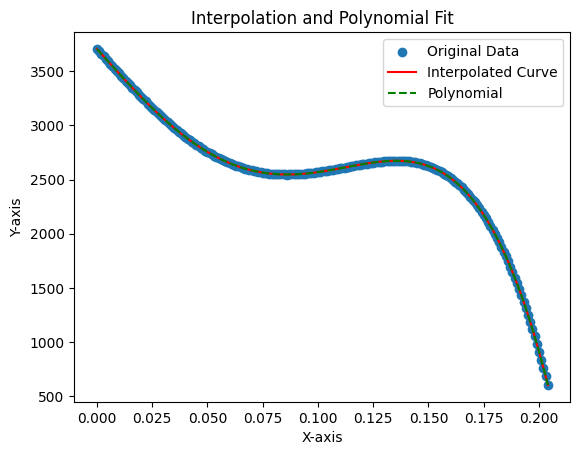

Original Y Values for the Roots:
For x = -229970220.699711, y = -5542254546637033430043483773431367860224.000000
For x = 0.135363, y = 2672.619793
For x = 0.086070, y = 2546.145410
For x = -0.049152, y = 4455.352751

Minimum b0: 2546.145409892201
Maximum b0: 2672.61979269077
From_b0: 2400
To_b0: 2700
Calculating min and max slope values for D1...
Point   |   x       |   y       |   Slope
---------------------------------------------
1       |   0.000   |   3704.655   |   -22694.776
2       |   0.001   |   3681.948   |   -22718.327
3       |   0.002   |   3659.223   |   -22728.528
4       |   0.003   |   3636.495   |   -22725.530
5       |   0.004   |   3613.776   |   -22709.598
6       |   0.005   |   3591.080   |   -22680.958
7       |   0.006   |   3568.418   |   -22639.852
8       |   0.007   |   3545.804   |   -22586.519
9       |   0.008   |   3523.249   |   -22521.194
10       |   0.009   |   3500.766   |   -22444.116
11       |   0.010   |   3478.365   |   -22355.524
12       | 

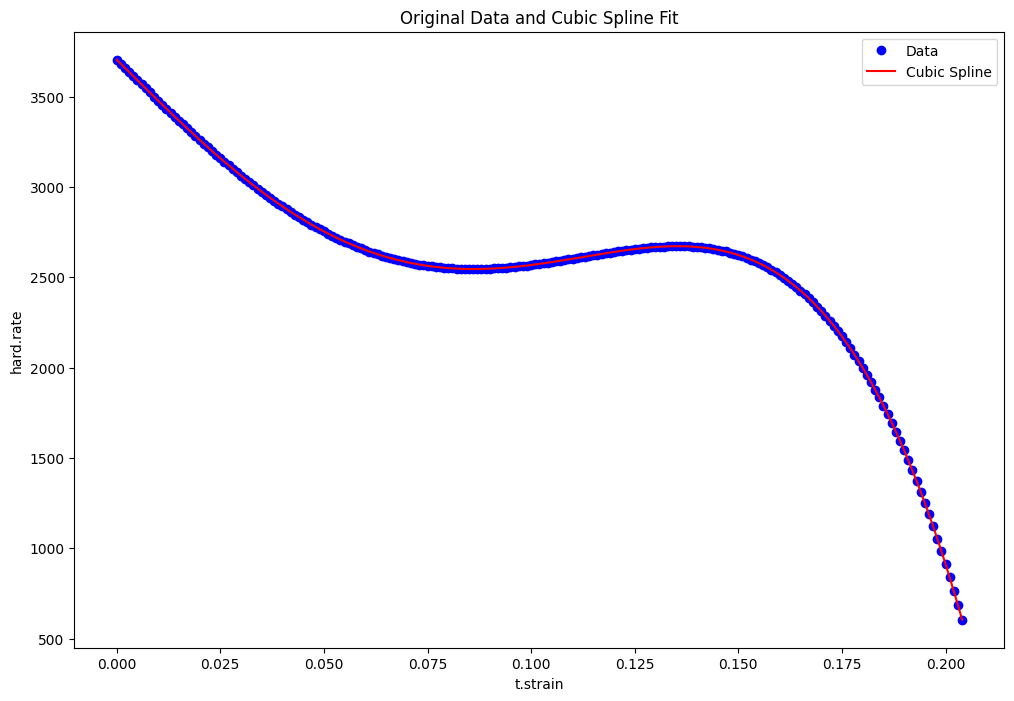

Data Point | x Value | y Value | Difference | Slope:
----------------------------------------------------
1       |   0.087   |   2546.259   |   254.168   |   242.612
2       |   0.088   |   2546.629   |   246.898   |   496.780
3       |   0.089   |   2547.250   |   239.392   |   743.677
4       |   0.090   |   2548.114   |   231.645   |   983.070

Average Slope of Printed Slopes: 616.5346115587133


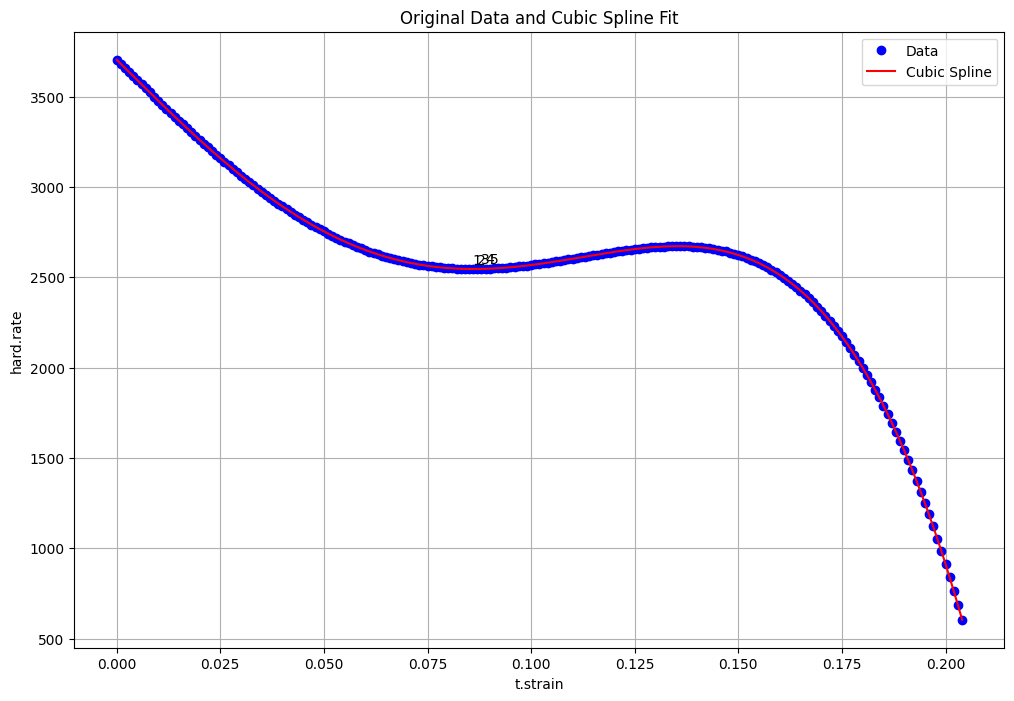


Minimum Slope: 242.61165902875788
Maximum Slope: 1214.7150006759255
Finding best parameters...
Plotting comparison...


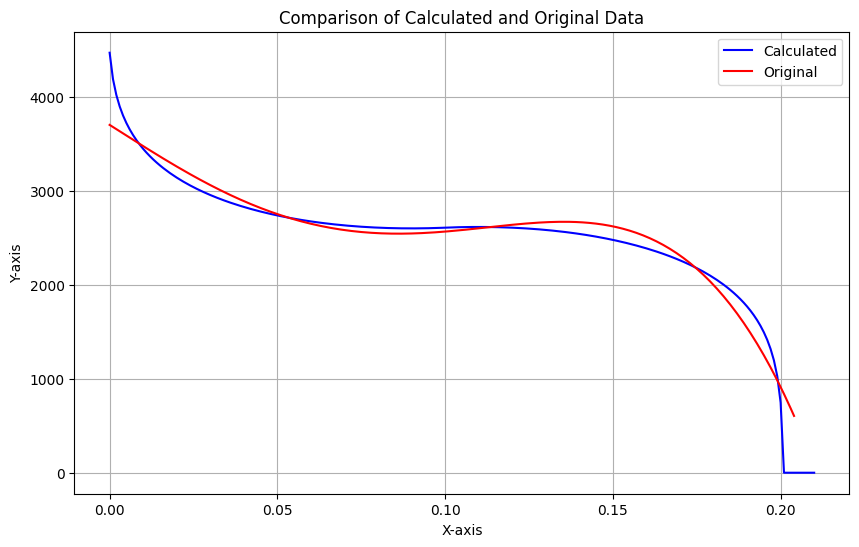

Extracting text and finding lemmas...
Finding max size chemical composition...

['Fe38.5Mn20Co20Cr15Si5Cu1.5', 'Fe50Mn30Co10Cr10HEA', 'Fe38.5Mn20Co20Cr15Si5Cu1.5', 'Fe38.5Mn20Co20Cr15Si5Cu1', 'S350S150D']

Maximum sized chemical composition: Fe38.5Mn20Co20Cr15Si5Cu1.5
Data has been updated in data.json
JSON DATA SAVED.


PROCESSING FOLDER: paper-2
Found Excel file: /content/drive/MyDrive/Colab Notebooks/Material_Science/allData/paper-2/Data.xlsx
Found PDF file: /content/drive/MyDrive/Colab Notebooks/Material_Science/allData/paper-2/5.pdf
Calculating B0 range...
Cubic Polynomial Coefficients: [ 7.60822297e+00  1.95937980e+06 -1.56997099e+06  4.20104933e+05
 -4.54570940e+04  4.55780102e+03]

Polynomial Equation: 7.608223 x^5 + 1959379.804664 x^4 + -1569970.990355 x^3 + 420104.933471 x^2 + -45457.093975 x^1 + 4557.801024

Derivative Equation: 38.041115 x^4 + 7837519.218654 x^3 + -4709912.971066 x^2 + 840209.866942 x^1 + -45457.093975

Roots (Zeros) of the Derivative Equation: [-2.06028191

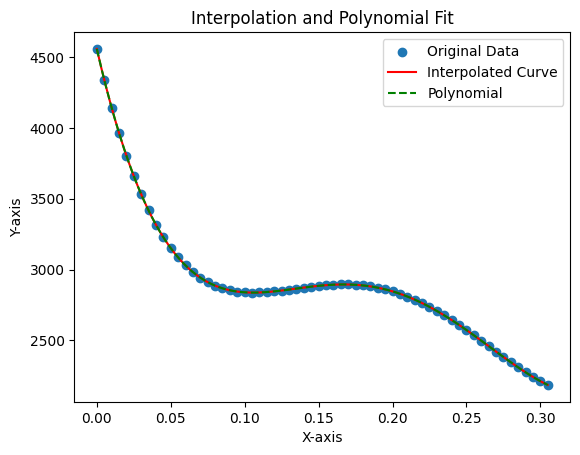

Original Y Values for the Roots:
For x = -206028.190990, y = 706087622000788120604246016.000000
For x = 0.328044, y = 2122.522112
For x = 0.167080, y = 2894.690660
For x = 0.105820, y = 2837.153081

Minimum b0: 2837.1530806493925
Maximum b0: 2894.690660304769
From_b0: 2700
To_b0: 3000
Calculating min and max slope values for D1...
Point   |   x       |   y       |   Slope
---------------------------------------------
1       |   0.000   |   4557.801   |   -45456.015
2       |   0.005   |   4340.823   |   -41373.142
3       |   0.010   |   4143.690   |   -37518.015
4       |   0.015   |   3965.269   |   -33887.197
5       |   0.020   |   3804.455   |   -30474.197
6       |   0.025   |   3660.174   |   -27273.016
7       |   0.030   |   3531.381   |   -24278.140
8       |   0.035   |   3417.059   |   -21483.423
9       |   0.040   |   3316.223   |   -18882.969
10       |   0.045   |   3227.915   |   -16471.103
11       |   0.050   |   3151.208   |   -14241.620
12       |   0.055   |   30

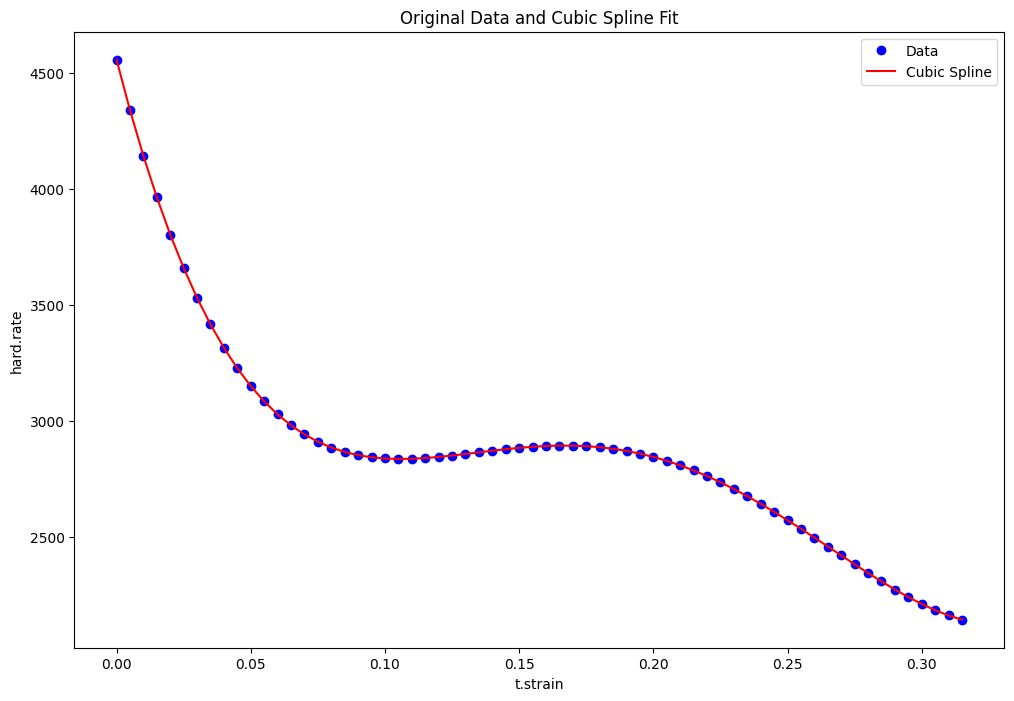

Data Point | x Value | y Value | Difference | Slope:
----------------------------------------------------
1       |   0.110   |   2838.032   |   390.475   |   407.807
2       |   0.115   |   2841.090   |   290.379   |   798.283
3       |   0.120   |   2845.848   |   195.809   |   1088.662
4       |   0.125   |   2851.819   |   107.186   |   1284.471

Average Slope of Printed Slopes: 894.8055814789032


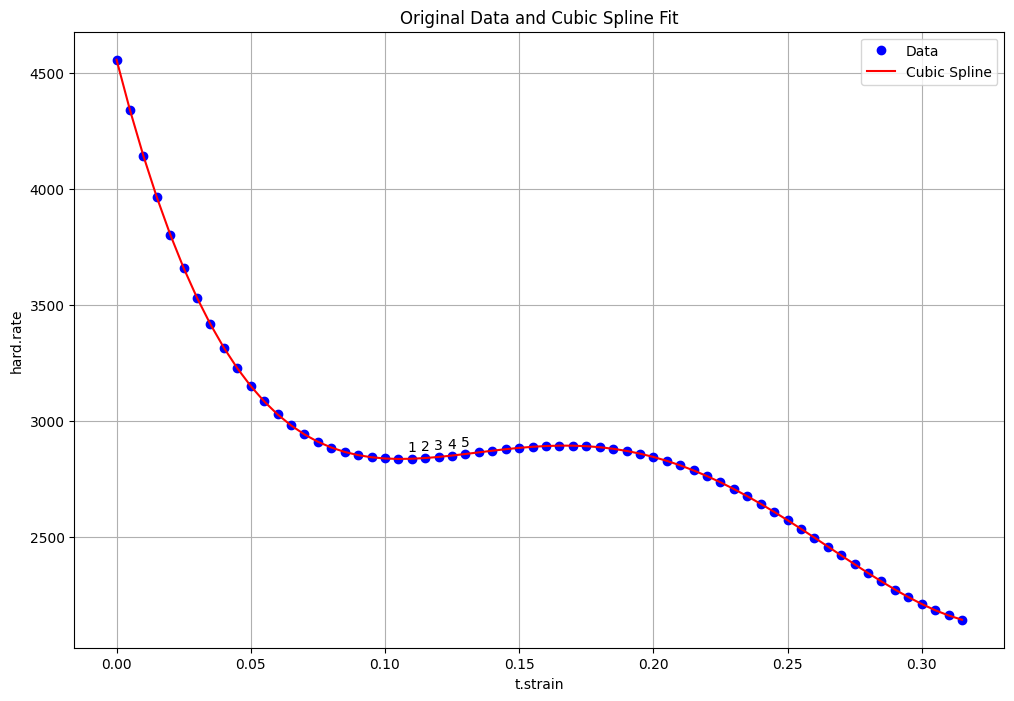


Minimum Slope: 407.8073942024265
Maximum Slope: 1391.6562578025782
Finding best parameters...
Plotting comparison...


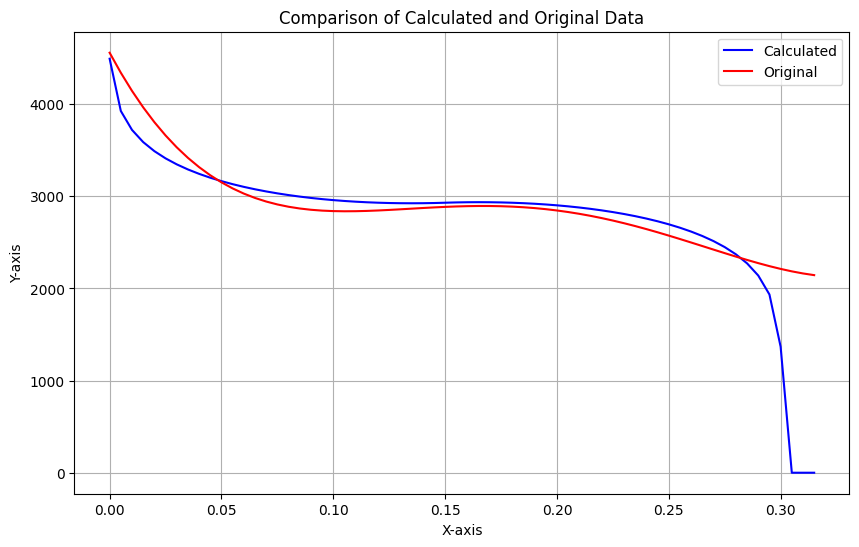

Extracting text and finding lemmas...
Finding max size chemical composition...

['Fe50Mn30Co10Cr10', 'Fe20Mn20Ni20Co20Cr20', 'Al1.5CoCr0.5FeNi0', 'FeMnNiCoCr', 'Fe50Mn30Co10Cr10HEA', 'Al0.1CoCrFeNi', 'Fe50Mn30Co10Cr10HEA', 'Al0.1CoCrFeNi', 'FSP350RPM', 'Fe50Mn30Co10Cr10', 'CoCrFeMnNi', 'Al0.1CoCrFeNi', 'CoCrFeMnNi']

Maximum sized chemical composition: Fe20Mn20Ni20Co20Cr20
Data has been updated in data.json
JSON DATA SAVED.



In [20]:
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Directory containing all the data folders
data_directory = "/content/drive/MyDrive/Colab Notebooks/Material_Science/allData"

# Loop through each folder in the data directory
for folder_name in os.listdir(data_directory):
    folder_path = os.path.join(data_directory, folder_name)

    # Check if the item in the directory is a folder
    if os.path.isdir(folder_path):
        print(f"\nPROCESSING FOLDER: {folder_name}")

        # Extract the file paths for the Excel and PDF files
        excel_file = None
        pdf_file = None

        # Loop through the files in the folder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            # Check if the file is an Excel file
            if file_name.endswith(".xlsx"):
                excel_file = file_path

            # Check if the file is a PDF file
            elif file_name.endswith(".pdf"):
                pdf_file = file_path

        # Ensure both Excel and PDF files are found
        if excel_file and pdf_file:
            print(f"Found Excel file: {excel_file}")
            print(f"Found PDF file: {pdf_file}")

            # Read Excel data
            # Read Excel data
            data = pd.read_excel(excel_file, usecols=[0, 1, 2])
            x_axis = data.columns[0]  # First column as x_axis - strain
            y1_axis = data.columns[1]  # Second column as y1_axis - stress
            y2_axis = data.columns[2]  # Third column as y2_axis - harding rate

            # x_axis = data.columns[0]  # First column as x_axis - strain
            # y1_axis = data.columns[1]  # Second column as y1_axis - stress
            # y2_axis = data.columns[2]  # Third column as y2_axis - harding rate

            # print(pd.read_excel(excel_file))
            data = pd.read_excel(excel_file, usecols=["t.strain", "t.stress", "hard.rate"])


            # Update global variables with file paths and column names
            file_path = excel_file
            pdf_file_path = pdf_file

            # Call the method and store the returned values
            analysis_results = analyze_pdf_data(file_path, pdf_file_path, keywords, x_axis, y2_axis, k_value)

            # Prepare the new details dictionary with the returned values
            new_details = {
                "b0": analysis_results["best_b0"],
                "d1": analysis_results["best_d1"],
                "d2": analysis_results["best_d2"],
                "ei": analysis_results["best_ei"],
                "ee": ee,
                "lemma": analysis_results["all_lemmas"],
                "composition": analysis_results["element_dict"],
                "link": link,
            }

            json_file_path = "data.json"
            update_json_data(json_file_path, new_details)

            print("JSON DATA SAVED.\n")
        else:
            print("Error: Both Excel and PDF files are required in each folder.")
    else:
        print(f"Skipping file: {folder_name}, it is not a folder.")
